In [1]:
#!pip install datasets ir_datasets rank_bm25 sentence_transformers langchain tf-keras ipywidgets faiss-cpu chromadb langchain_community

## Import Libraries

In [2]:
import numpy as np
from collections import defaultdict
import os
from dotenv import load_dotenv
from datasets import load_dataset
from ir_datasets import load as load_ir
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer




import faiss
import time

#!pip install chromadb
from sentence_transformers import CrossEncoder
import chromadb
from chromadb.config import Settings
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain.retrievers import EnsembleRetriever
from langchain_community.embeddings import SentenceTransformerEmbeddings


import evaluate
from openai import OpenAI


##  Download data from https://huggingface.co/datasets/mandarjoshi/trivia_qa/tree/main/unfiltered

In [3]:
from datasets import load_dataset

ds = load_dataset("parquet", data_files="train-00000-of-00047.parquet", split="train[:50]")


In [4]:
print(ds[0].keys())


dict_keys(['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer'])


In [5]:
ds[0]

{'question': 'Who was President when the first Peanuts cartoon was published?',
 'question_id': 'tc_0',
 'question_source': 'http://www.triviacountry.com/',
 'entity_pages': {'doc_source': ['TagMe'],
  'filename': ['Peanuts.txt'],
  'title': ['Peanuts'],
  'wiki_context': ['Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published in all, making it "arguably the longest story ever told by one human being".  At its peak, Peanuts ran in over 2,600 newspapers, with a readership of 355 million in 75 countries, and was translated into 21 languages.  It helped to cement the four-panel gag strip as the standard in the United States,  and together with its merchandise earned Schulz more than $1 billion. Reprints of the strip are still syndicated and run i

## Search results for question

In [27]:
len(ds[0]['search_results'])

6

In [7]:
ds[0]['search_results'].keys()

dict_keys(['description', 'filename', 'rank', 'title', 'url', 'search_context'])

## Number of documents found

In [8]:
len(ds[0]['search_results']['search_context'])

9

In [9]:
print(ds[0]['search_results']['search_context'][0])

Peanuts | Peanuts Wiki | Fandom powered by Wikia
Charles M. Schulz drawing Snoopy .
Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanuts strips were published. The strip was one of the most popular and influential in the history of the medium, and considered the most beloved comic strips of all time. It was "arguably the longest story ever told by one human being,'"' according to Professor Robert Thompson of Syracuse University. At its peak, Peanuts ran in over 2,600 newspapers, with a readership of 355 million in 75 countries, and was translated into 21 languages. It helped to cement the four-panel gag strip as the standard in the United States. Reprints of the strip are still syndicated and run in many newspapers.
In addition, Peanuts achieved considerable success for its television specials, several of which, including 

In [10]:
print(ds[0]['search_results']['search_context'][4])

A Brief History of Charles Schulz's 'Peanuts' Comic Strip - TIME
Follow @TIME
When Alex Davis was 2 years old, he pointed to a drawing his father had done and exclaimed, "Snoopy!" The problem: his father was Jim Davis, the creator of Garfield, and the picture was of the cat he made famous. Charles Schulz's black-and-white dog is so beloved, though, that a lasagna-loving cat can't even compete. Saturday, Oct. 2, marks 60 years since Schulz's first Peanuts strip hit newspapers. Since then, Snoopy, Charlie Brown and the gang have become the most recognizable cartoon characters in America  and have left an indelible mark on American culture.
Yet leave it to the man behind Charlie Brown to experience disappointment before success. In 1947 Schulz started a cartoon feature called L'il Folks for the St. Paul Pioneer Press. It was a flop, never achieving a permanent spot in the paper. In 1950 he compiled his strips and sold the series to the United Features Syndicate, which changed its name to

In [11]:
print(ds[0]['entity_pages']['wiki_context'][0])

Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published in all, making it "arguably the longest story ever told by one human being".  At its peak, Peanuts ran in over 2,600 newspapers, with a readership of 355 million in 75 countries, and was translated into 21 languages.  It helped to cement the four-panel gag strip as the standard in the United States,  and together with its merchandise earned Schulz more than $1 billion. Reprints of the strip are still syndicated and run in almost every U.S. newspaper.

The strip focuses entirely on a miniature society of young children, with no shown adult characters. The main character, Charlie Brown, is meek, nervous, and lacks self-confidence. He is unable to fly a kite, win a baseball game, or kick a foo

# Prepare a dataset for document retrieval:
# - Deduplicate documents and store them with optional metadata
# - Build mappings of question index -> gold documents
# - Build mappings of question index -> candidate documents (including golds)
# - Compute basic stats: total unique docs, avg candidates and golds per question


In [ ]:
Relevant document == document in which answr is located , gold_id 

candidate document == search results



In [12]:


# Limit for teaching purposes (you can increase)
N = len(ds)  # or smaller, e.g., 50

doc_texts = []        # all unique docs for FAISS
doc_meta  = []        # optional metadata
doc_key_to_id = {}    # map text -> index for deduplication

q_gold = {}       # question idx -> set(doc_id) (gold)
q_candidates = {} # question idx -> list(doc_id) (candidate pool)

def add_doc(text, meta=None):
    t = text.strip()
    if not t:
        return None
    if t in doc_key_to_id:
        return doc_key_to_id[t]
    doc_id = len(doc_texts)
    doc_texts.append(t)
    doc_meta.append(meta)
    doc_key_to_id[t] = doc_id
    return doc_id

for i in range(N):
    item = ds[i]
    
    # --- Gold docs ---
    gold_ids = set()
    for txt in item["entity_pages"]["wiki_context"]:
        did = add_doc(txt, meta={"type":"gold"})
        if did is not None:
            gold_ids.add(did)
    
    # --- Candidate docs ---
    cand_ids = []
    for txt in item["search_results"]["search_context"]:
        did = add_doc(txt, meta={"type":"candidate"})
        if did is not None:
            cand_ids.append(did)
    
    # Ensure gold docs are in candidate list
    for gid in list(gold_ids):
        if gid not in cand_ids:
            cand_ids.append(gid)
    
    q_gold[i] = gold_ids
    q_candidates[i] = cand_ids

# Summary
print("Processed questions:", N)
print("Unique documents in corpus:", len(doc_texts))
avg_cands = sum(len(v) for v in q_candidates.values()) / max(1, N)
avg_golds = sum(len(v) for v in q_gold.values()) / max(1, N)
print(f"Avg candidates per question: {avg_cands:.2f}")
print(f"Avg gold docs per question: {avg_golds:.2f}")


Processed questions: 50
Unique documents in corpus: 528
Avg candidates per question: 10.76
Avg gold docs per question: 1.66


# Build embeddings and FAISS index for candidate documents:
# 1. Load a SentenceTransformer model for generating dense embeddings.
# 2. Compute approximate token count and total documents for info.
# 3. Encode all candidate documents into embeddings and measure time.
# 4. Create a FAISS index and add embeddings for fast similarity search.
# 5. Print timing and summary stats.


In [13]:


# Step 2a: Build embeddings for all candidate docs
model = SentenceTransformer('all-MiniLM-L6-v2')

# Count approximate tokens (split by space)
num_tokens = sum(len(doc.split()) for doc in doc_texts)
print("Approximate total tokens in candidate docs:", num_tokens)
print("Total candidate docs:", len(doc_texts))

# Measure time for embedding
start_time = time.time()
cand_embeddings = model.encode(doc_texts, convert_to_numpy=True, show_progress_bar=True)
end_time = time.time()
print(f"Time taken to embed {len(doc_texts)} docs ({num_tokens} tokens approx): {end_time - start_time:.2f} seconds")

# Step 2b: Build FAISS index
start_index_time = time.time()
embedding_dim = cand_embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance
index.add(cand_embeddings)
end_index_time = time.time()
print(f"Time taken to add embeddings to FAISS index: {end_index_time - start_index_time:.2f} seconds")
print("FAISS index built with", index.ntotal, "documents")


Approximate total tokens in candidate docs: 1532383
Total candidate docs: 528


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

Time taken to embed 528 docs (1532383 tokens approx): 53.62 seconds
Time taken to add embeddings to FAISS index: 0.00 seconds
FAISS index built with 528 documents


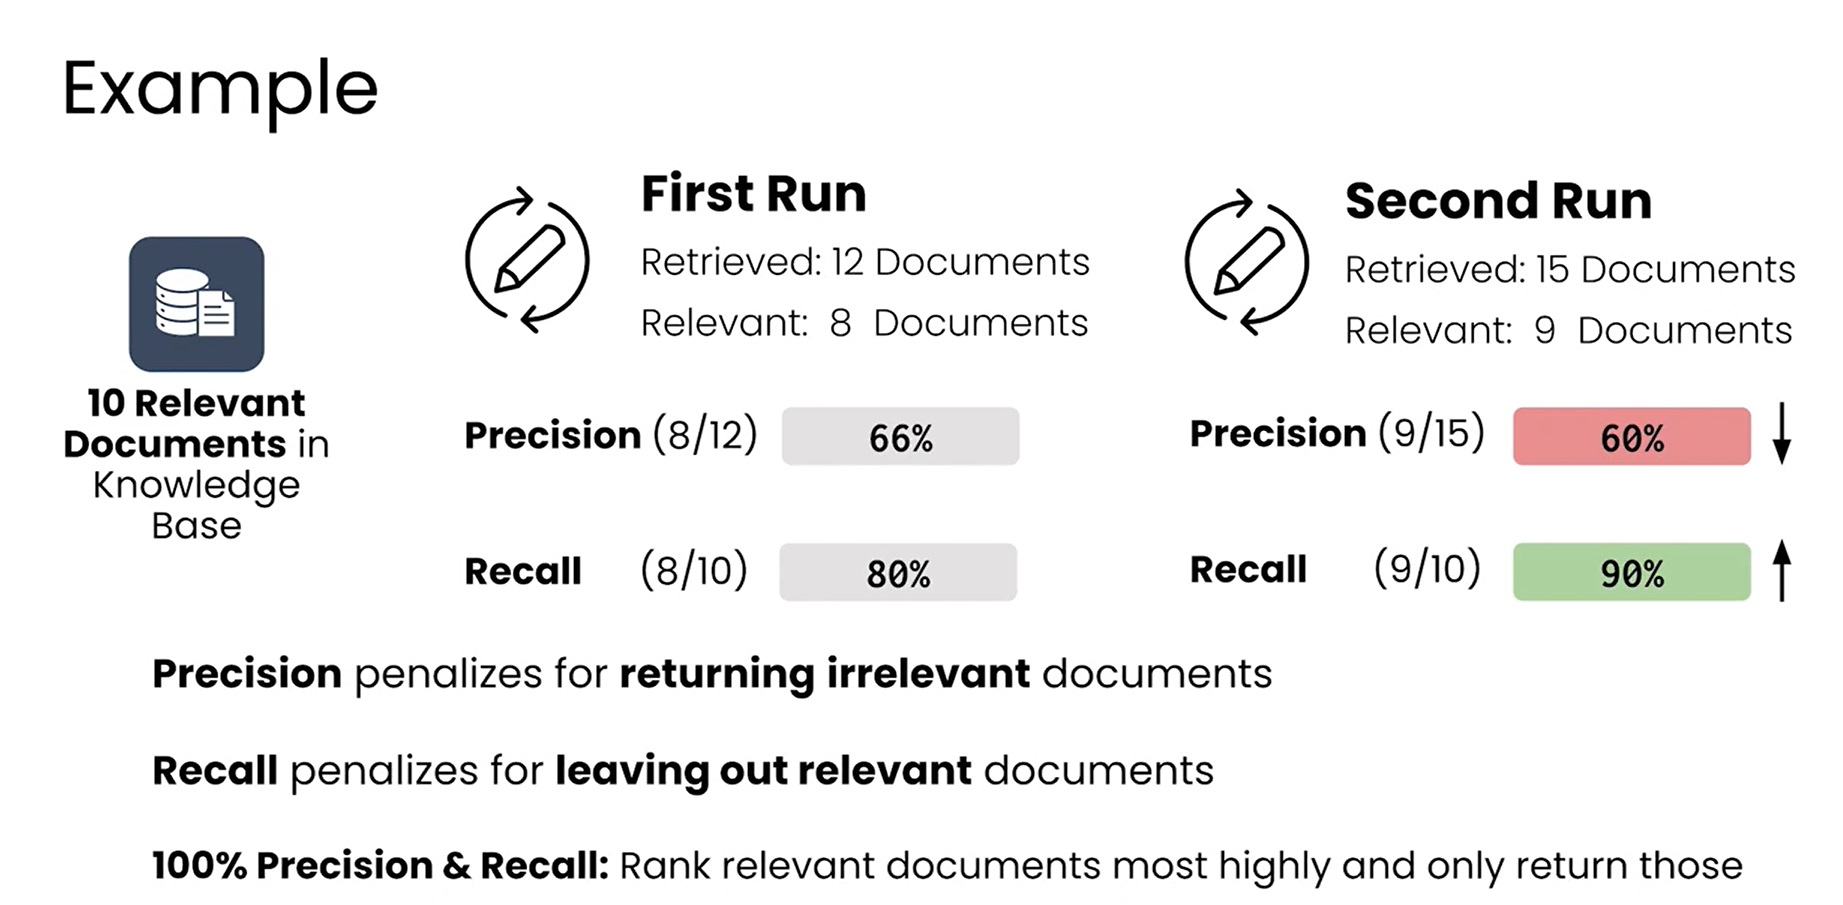

In [14]:
from IPython.display import display
from PIL import Image

# Load image
image = Image.open("precision_recall.jpg")

display(image)


# Retrieve and evaluate documents for a single question:
# 1. Select a question and its gold document IDs.
# 2. Embed the question using the same model as for candidates.
# 3. Retrieve top-k most similar documents from the FAISS index.
# 4. Display retrieved snippets and mark which are gold.
# 5. Compute basic retrieval metrics: Precision@k, Recall@k, and Reciprocal Rank (RR).


In [15]:
# Pick one question
i = 0
question = ds[i]["question"]
gold_ids = q_gold[i]  # set of gold doc IDs

print("Question:", question)
print("Gold doc IDs:", gold_ids)

# Embed the question
q_emb = model.encode(question, convert_to_numpy=True)

# Retrieve top-k docs
top_k = 5
D, I = index.search(np.expand_dims(q_emb, axis=0), top_k)
retrieved_ids = I[0]

print("\nTop-k retrieved doc IDs:", retrieved_ids)

# Show retrieved snippets and indicate gold
for rank, doc_id in enumerate(retrieved_ids, start=1):
    snippet = doc_texts[doc_id][:300].replace("\n", " ")
    is_gold = "✅ GOLD" if doc_id in gold_ids else "❌"
    print(f"\nRank {rank} - Doc ID {doc_id} {is_gold}:\n{snippet} ...")

# Compute metrics for this single question
precision = len(gold_ids & set(retrieved_ids)) / top_k
recall = len(gold_ids & set(retrieved_ids)) / max(1, len(gold_ids))
rr = 0
for rank, doc_id in enumerate(retrieved_ids):
    if doc_id in gold_ids:
        rr = 1 / (rank + 1)
        break

print(f"\nMetrics for this question:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")


Question: Who was President when the first Peanuts cartoon was published?
Gold doc IDs: {0}

Top-k retrieved doc IDs: [5 1 4 0 3]

Rank 1 - Doc ID 5 ❌:
A Brief History of Charles Schulz's 'Peanuts' Comic Strip - TIME Follow @TIME When Alex Davis was 2 years old, he pointed to a drawing his father had done and exclaimed, "Snoopy!" The problem: his father was Jim Davis, the creator of Garfield, and the picture was of the cat he made famous. Charles S ...

Rank 2 - Doc ID 1 ❌:
Peanuts | Peanuts Wiki | Fandom powered by Wikia Charles M. Schulz drawing Snoopy . Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanu ...

Rank 3 - Doc ID 4 ❌:
Peanuts by Charles Schulz  | Read Comic Strips at GoComics.com Share Link Explore Peanuts ...

Rank 4 - Doc ID 0 ✅ GOLD:
Peanuts is a syndicated daily and Sunday American comic strip written and

In [ ]:
precision = total no of relevent documents in all retrieved / total no of retrieved documents (k)

recall = total no of relevent documents in all retrieved / total no of relevent documents

In [ ]:
query = "Who is the president of India?"



gold doc id = {0,3} # actual answer is in document 0 and 3

5

Top-k retrieved doc IDs: [5 1 4 0 6] 

Reciprocal Rank (RR): 1/4 = 0.25

Reciprocal Rank (RR): 1/5 = 0.20

mean reciprocal rank will be = (0.25+0.20)/2 = 0.225


preicision = 1/5 = 0.20

recall = 1/2


first doc RR = 0 / 1=0
second doc RR = 0 / 2 = 0

fourth doc RR = 1 / 4 = 0.25

ffifth doc RR = 0 / 5 = 0




In [ ]:
recall = total no of relevent documents in all retrieved / total no of relevent documents

recall = 1/1
 = 1

# Re-rank retrieved documents using a cross-encoder:
# 1. Load a cross-encoder model fine-tuned for relevance/QA.
# 2. Retrieve top-k candidate documents from FAISS using sentence embeddings.
# 3. Create (question, document) pairs for cross-encoder scoring.
# 4. Compute relevance scores and sort documents by descending score.
# 5. Display reranked top-k snippets and indicate gold documents.
# 6. Compute retrieval metrics (Precision@k, Recall@k, Reciprocal Rank) after reranking.


In [16]:


# Load cross-encoder (fine-tuned for relevance / QA)
cross_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Example: single question
i = 0
question = ds[i]["question"]
gold_ids = q_gold[i]

# Step 1: retrieve top-k using FAISS
top_k = 5
q_emb = model.encode(question, convert_to_numpy=True)  # use your sentence-transformer
D, I = index.search(np.expand_dims(q_emb, axis=0), top_k)
retrieved_ids = I[0]

# Step 2: prepare pairs for cross-encoder scoring
pairs = [[question, doc_texts[doc_id]] for doc_id in retrieved_ids]

# Step 3: compute relevance scores
scores = cross_model.predict(pairs)

# Step 4: sort by score (descending)
sorted_idx = np.argsort(scores)[::-1]
reranked_ids = [retrieved_ids[idx] for idx in sorted_idx]

# Step 5: display reranked docs and compute metrics
print("Reranked top-k doc IDs:", reranked_ids)
for rank, doc_id in enumerate(reranked_ids, start=1):
    snippet = doc_texts[doc_id][:300].replace("\n", " ")
    is_gold = "✅ GOLD" if doc_id in gold_ids else "❌"
    print(f"\nRank {rank} - Doc ID {doc_id} {is_gold}:\n{snippet} ...")

# Step 6: compute metrics after reranking
precision = len(gold_ids & set(reranked_ids)) / top_k
recall = len(gold_ids & set(reranked_ids)) / max(1, len(gold_ids))
rr = 0
for rank, doc_id in enumerate(reranked_ids):
    if doc_id in gold_ids:
        rr = 1 / (rank + 1)
        break

print(f"\nMetrics after reranking:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")


Reranked top-k doc IDs: [np.int64(1), np.int64(0), np.int64(5), np.int64(3), np.int64(4)]

Rank 1 - Doc ID 1 ❌:
Peanuts | Peanuts Wiki | Fandom powered by Wikia Charles M. Schulz drawing Snoopy . Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanu ...

Rank 2 - Doc ID 0 ✅ GOLD:
Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published ...

Rank 3 - Doc ID 5 ❌:
A Brief History of Charles Schulz's 'Peanuts' Comic Strip - TIME Follow @TIME When Alex Davis was 2 years old, he pointed to a drawing his father had done and exclaimed, "Snoopy!" The problem: his father was Jim Davis, the creato

# Trial with CromaDB 

In [17]:


# Initialize Chroma client with new configuration
client = chromadb.Client(Settings())


# Store candidate documents in a Chroma vector database:
# 1. Create a Chroma collection (delete if it already exists).
# 2. Prepare document IDs and optional metadata.
# 3. Add documents and their embeddings to the collection.
# 4. Print confirmation of collection creation and document count.


In [18]:
# Install Chroma if not already
# pip install chromadb



# Create a collection
collection_name = "candidate_docs"
if collection_name in [c.name for c in client.list_collections()]:
    client.delete_collection(collection_name)
collection = client.create_collection(name=collection_name)

# Add documents + embeddings to Chroma
ids = [str(i) for i in range(len(doc_texts))]  # simple string IDs
metadatas = [{"source": "candidate_doc"} for _ in doc_texts]  # optional metadata

collection.add(
    documents=doc_texts,
    embeddings=cand_embeddings.tolist(),  # Chroma expects list of lists
    ids=ids,
    metadatas=metadatas
)

print(f"Chroma collection '{collection_name}' created with {len(doc_texts)} documents.")


Chroma collection 'candidate_docs' created with 528 documents.


# Single-question retrieval demo using Chroma:
# 1. Select a question and its gold documents.
# 2. Embed the question using the same embedding model.
# 3. Query the Chroma collection for top-k most similar documents.
# 4. Display retrieved documents with a check for gold matches.
# 5. Compute retrieval metrics: Precision@k, Recall@k, and Reciprocal Rank (RR).


In [19]:
# ----------------- Single Question Retrieval Demo -----------------
sample = ds[0]
question = sample["question"]
gold_docs = set(sample["entity_pages"]["wiki_context"])  # ground truth docs

print("Question:", question)
print("Gold doc snippet:", list(gold_docs)[0][:300], "...")

# Embed question
query_emb = model.encode(question).tolist()

# Retrieve top-k from Chroma
top_k = 5
results = collection.query(
    query_embeddings=[query_emb],
    n_results=top_k
)

retrieved_docs = results['documents'][0]
retrieved_ids = results['ids'][0]  # get document IDs from Chroma

# Print ranked docs with gold check
print("\nTop-k retrieved docs:")
for rank, (doc_id, doc) in enumerate(zip(retrieved_ids, retrieved_docs), start=1):
    check = "✅ GOLD" if doc in gold_docs else "❌"
    snippet = doc[:500].replace("\n", " ")  # first 500 chars, remove line breaks
    print(f"Rank {rank} - Doc ID {doc_id} {check}:\n{snippet}\n")

# Compute metrics
retrieved_set = set(retrieved_docs)
precision = len(gold_docs & retrieved_set) / top_k
recall = len(gold_docs & retrieved_set) / max(1, len(gold_docs))

rr = 0
for rank, doc in enumerate(retrieved_docs):
    if doc in gold_docs:
        rr = 1 / (rank + 1)
        break

print("Metrics after retrieval:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")


Question: Who was President when the first Peanuts cartoon was published?
Gold doc snippet: Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published ...

Top-k retrieved docs:
Rank 1 - Doc ID 5 ❌:
A Brief History of Charles Schulz's 'Peanuts' Comic Strip - TIME Follow @TIME When Alex Davis was 2 years old, he pointed to a drawing his father had done and exclaimed, "Snoopy!" The problem: his father was Jim Davis, the creator of Garfield, and the picture was of the cat he made famous. Charles Schulz's black-and-white dog is so beloved, though, that a lasagna-loving cat can't even compete. Saturday, Oct. 2, marks 60 years since Schulz's first Peanuts strip hit newspapers. Since then, Snoopy,

Rank 2 - Doc ID 1 ❌:
Peanuts | Peanuts Wiki | Fandom powe

# Single-question retrieval + reranking using Chroma and a Cross-Encoder:
# 1. Select a question and its gold documents.
# 2. Embed the question and retrieve top-k documents from Chroma.
# 3. Use a cross-encoder to score (question, document) pairs for relevance.
# 4. Rerank documents by descending score.
# 5. Display reranked documents with gold match check.
# 6. Compute retrieval metrics (Precision@k, Recall@k, Reciprocal Rank) after reranking.


In [20]:


# ----------------- Single Question Retrieval + Rerank -----------------
sample = ds[0]
question = sample["question"]
gold_docs = set(sample["entity_pages"]["wiki_context"])  # ground truth docs

print("Question:", question)
print("Gold doc snippet:", list(gold_docs)[0][:300], "...")

# Embed question
query_emb = model.encode(question).tolist()

# Retrieve top-k from Chroma
top_k = 5
results = collection.query(
    query_embeddings=[query_emb],
    n_results=top_k
)

retrieved_docs = results['documents'][0]
retrieved_ids = results['ids'][0]  # doc IDs

# ----------------- Rerank with Cross-Encoder -----------------
cross_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
pairs = [[question, doc] for doc in retrieved_docs]
scores = cross_model.predict(pairs)

# Sort by scores descending
reranked = sorted(zip(scores, retrieved_ids, retrieved_docs), reverse=True)
reranked_scores, reranked_ids, reranked_docs = zip(*reranked)

# Print reranked top-k
print("\nReranked top-k docs:")
for rank, (doc_id, doc) in enumerate(zip(reranked_ids, reranked_docs), start=1):
    check = "✅ GOLD" if doc in gold_docs else "❌"
    snippet = doc[:500].replace("\n", " ")
    print(f"Rank {rank} - Doc ID {doc_id} {check}:\n{snippet}\n")

# ----------------- Compute Metrics -----------------
retrieved_set = set(reranked_docs)
precision = len(gold_docs & retrieved_set) / top_k
recall = len(gold_docs & retrieved_set) / max(1, len(gold_docs))

rr = 0
for rank, doc in enumerate(reranked_docs):
    if doc in gold_docs:
        rr = 1 / (rank + 1)
        break

print("Metrics after reranking:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")


Question: Who was President when the first Peanuts cartoon was published?
Gold doc snippet: Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published ...

Reranked top-k docs:
Rank 1 - Doc ID 1 ❌:
Peanuts | Peanuts Wiki | Fandom powered by Wikia Charles M. Schulz drawing Snoopy . Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanuts strips were published. The strip was one of the most popular and influential in the history of the medium, and considered the most beloved comic strips of all time. It was "arguably the longest sto

Rank 2 - Doc ID 0 ✅ GOLD:
Peanuts is a syndicated daily an

## BM25 Retriever

In [21]:


# SentenceTransformers model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for candidate docs
cand_embeddings = model.encode(doc_texts, convert_to_numpy=True)


# Create / reset collection
collection_name = "candidate_docs"
if collection_name in [c.name for c in client.list_collections()]:
    client.delete_collection(collection_name)

collection = client.create_collection(name=collection_name)

# Add documents + embeddings
ids = [str(i) for i in range(len(doc_texts))]
metadatas = [{"source": "candidate_doc"} for _ in doc_texts]

collection.add(
    documents=doc_texts,
    embeddings=cand_embeddings.tolist(),
    ids=ids,
    metadatas=metadatas
)

print(f"Chroma collection '{collection_name}' created with {len(doc_texts)} documents.")




# LangChain embedding wrapper (same model as above)
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Wrap Chroma collection
vector_store = Chroma(
    client=client,
    collection_name=collection_name,
    embedding_function=embedding_function
)
chroma_retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}
)

# BM25 retriever
documents = [
    Document(page_content=text, metadata=meta)
    for text, meta in zip(doc_texts, metadatas)
]
bm25 = BM25Retriever.from_documents(documents, k=5)

# Hybrid retriever
hybrid = EnsembleRetriever(
    retrievers=[bm25, chroma_retriever],
    weights=[0.7, 0.3]
)

# ----------------- Single Question Hybrid Retrieval -----------------
sample = ds[0]
question = sample["question"]
gold_docs = set(sample["entity_pages"]["wiki_context"])

print("Question:", question)
print("Gold doc snippet:", list(gold_docs)[0][:300], "...")

# Run hybrid retrieval
top_k = 5
results = hybrid.get_relevant_documents(question)


Chroma collection 'candidate_docs' created with 528 documents.


C:\Users\Admin\AppData\Local\Temp\ipykernel_10728\4093833122.py:32: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\Admin\AppData\Local\Temp\ipykernel_10728\4093833122.py:35: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


Question: Who was President when the first Peanuts cartoon was published?
Gold doc snippet: Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published ...


C:\Users\Admin\AppData\Local\Temp\ipykernel_10728\4093833122.py:68: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = hybrid.get_relevant_documents(question)


In [22]:
top_k = 5
# Deduplicate based on `page_content` or some unique id/key
seen = set()
unique_docs = []
for doc in results:
    key = doc.page_content
    if key not in seen:
        seen.add(key)
        unique_docs.append(doc)
    if len(unique_docs) >= top_k:
        break

retrieved_docs = [doc.page_content for doc in unique_docs]

# Print ranked docs
print("\nTop-k retrieved docs (Hybrid deduped/truncated):")
for rank, doc in enumerate(retrieved_docs, start=1):
    check = "✅ GOLD" if doc in gold_docs else "❌"
    snippet = doc[:500].replace("\n", " ")
    print(f"Rank {rank} {check}:\n{snippet}\n")
# Compute metrics
retrieved_set = set(retrieved_docs)
precision = len(gold_docs & retrieved_set) / top_k
recall = len(gold_docs & retrieved_set) / max(1, len(gold_docs))
rr = 0
for rank, doc in enumerate(retrieved_docs):
    if doc in gold_docs:
        rr = 1 / (rank + 1)
        break

print("Metrics after Hybrid retrieval:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")


Top-k retrieved docs (Hybrid deduped/truncated):
Rank 1 ❌:
Peanuts | Peanuts Wiki | Fandom powered by Wikia Charles M. Schulz drawing Snoopy . Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanuts strips were published. The strip was one of the most popular and influential in the history of the medium, and considered the most beloved comic strips of all time. It was "arguably the longest sto

Rank 2 ❌:
Frequently Asked Questions - Charles M. Schulz Museum Charles M. Schulz Museum The Peanuts Comic Strip Why is the comic strip named Peanuts? Originally, Charles Schulz named his strip Li’l Folks, but when it became syndicated in 1950 by United Feature Syndicate, there was concern about possible copyright infringement with a cartoon called Little Folks by Tack Knight that had been published in the 1930s. Schulz suggested Char

In [23]:


# Load cross-encoder (fine-tuned for relevance / QA)
cross_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Example: single question
i = 0
question = ds[i]["question"]
gold_ids = q_gold[i]

# Step 1: retrieve top-k using FAISS
top_k = 5
q_emb = model.encode(question, convert_to_numpy=True)  # use your sentence-transformer
D, I = index.search(np.expand_dims(q_emb, axis=0), top_k)
retrieved_ids = I[0]

# Step 2: prepare pairs for cross-encoder scoring
pairs = [[question, doc_texts[doc_id]] for doc_id in retrieved_ids]

# Step 3: compute relevance scores
scores = cross_model.predict(pairs)

# Step 4: sort by score (descending)
sorted_idx = np.argsort(scores)[::-1]
reranked_ids = [retrieved_ids[idx] for idx in sorted_idx]

# Step 5: display reranked docs and compute metrics
print("Reranked top-k doc IDs:", reranked_ids)
for rank, doc_id in enumerate(reranked_ids, start=1):
    snippet = doc_texts[doc_id][:300].replace("\n", " ")
    is_gold = "✅ GOLD" if doc_id in gold_ids else "❌"
    print(f"\nRank {rank} - Doc ID {doc_id} {is_gold}:\n{snippet} ...")

# Step 6: compute metrics after reranking
precision = len(gold_ids & set(reranked_ids)) / top_k
recall = len(gold_ids & set(reranked_ids)) / max(1, len(gold_ids))
rr = 0
for rank, doc_id in enumerate(reranked_ids):
    if doc_id in gold_ids:
        rr = 1 / (rank + 1)
        break

print(f"\nMetrics after reranking:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")


Reranked top-k doc IDs: [np.int64(1), np.int64(0), np.int64(5), np.int64(3), np.int64(4)]

Rank 1 - Doc ID 1 ❌:
Peanuts | Peanuts Wiki | Fandom powered by Wikia Charles M. Schulz drawing Snoopy . Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanu ...

Rank 2 - Doc ID 0 ✅ GOLD:
Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published ...

Rank 3 - Doc ID 5 ❌:
A Brief History of Charles Schulz's 'Peanuts' Comic Strip - TIME Follow @TIME When Alex Davis was 2 years old, he pointed to a drawing his father had done and exclaimed, "Snoopy!" The problem: his father was Jim Davis, the creato

In [24]:
# ------------------- Imports -------------------


# ------------------- Load OpenAI Key -------------------
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# ------------------- Models -------------------
# FAISS embedding model (used for initial retrieval)
model = SentenceTransformer('all-MiniLM-L6-v2')

# CrossEncoder for reranking
cross_model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# ------------------- Evaluation Metrics -------------------
rouge = evaluate.load("rouge")
bleu = evaluate.load("bleu")
bertscore = evaluate.load("bertscore")

# ------------------- Example: Single Question -------------------
i = 0
question = ds[i]["question"]
gold_ids = q_gold[i]       # gold document IDs
gold_answers = ds[i]["answer"]  # reference answer

# ------------------- Step 1: Retrieve top-k using FAISS -------------------
top_k = 5
q_emb = model.encode(question, convert_to_numpy=True)
D, I = index.search(np.expand_dims(q_emb, axis=0), top_k)
retrieved_ids = I[0]

# ------------------- Step 2: CrossEncoder reranking -------------------
pairs = [[question, doc_texts[doc_id]] for doc_id in retrieved_ids]
scores = cross_model.predict(pairs)
sorted_idx = np.argsort(scores)[::-1]
reranked_ids = [retrieved_ids[idx] for idx in sorted_idx]

# ------------------- Step 3: Display reranked docs -------------------
print("Reranked top-k doc IDs:", reranked_ids)
for rank, doc_id in enumerate(reranked_ids, start=1):
    snippet = doc_texts[doc_id][:300].replace("\n", " ")
    is_gold = "✅ GOLD" if doc_id in gold_ids else "❌"
    print(f"\nRank {rank} - Doc ID {doc_id} {is_gold}:\n{snippet} ...")

# ------------------- Step 4: Compute retrieval metrics -------------------
precision = len(gold_ids & set(reranked_ids)) / top_k
recall = len(gold_ids & set(reranked_ids)) / max(1, len(gold_ids))
rr = 0
for rank, doc_id in enumerate(reranked_ids):
    if doc_id in gold_ids:
        rr = 1 / (rank + 1)
        break

print(f"\nMetrics after reranking:")
print(f"Precision@{top_k}: {precision:.3f}")
print(f"Recall@{top_k}: {recall:.3f}")
print(f"Reciprocal Rank (RR): {rr:.3f}")

# ------------------- Step 5: Generate answer using OpenAI LLM -------------------
# Prepare context from top-k reranked docs
context = "\n\n".join([doc_texts[doc_id] for doc_id in reranked_ids])
prompt = f"""
You are a helpful assistant. Use the following context to answer the question.

Context:
{context}

Question: {question}

Answer:
"""

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": prompt}],
    max_tokens=300,
    temperature=0.2
)
answer = response.choices[0].message.content
print("\nGenerated Answer:\n", answer)

# ------------------- Step 6: Evaluate generated answer -------------------
ref = gold_answers['aliases'][0]  # use first reference answer

# ROUGE
rouge_result = rouge.compute(predictions=[answer], references=[ref])
# BLEU
print("ROUGE:")
for roguer, score in rouge_result.items():
    print(f"{roguer}: {score:.4f}")



Reranked top-k doc IDs: [np.int64(1), np.int64(0), np.int64(5), np.int64(3), np.int64(4)]

Rank 1 - Doc ID 1 ❌:
Peanuts | Peanuts Wiki | Fandom powered by Wikia Charles M. Schulz drawing Snoopy . Peanuts is a syndicated daily and Sunday comic strip written and illustrated by Charles M. Schulz , which ran from October 2, 1950, to February 13, 2000 (the day after Schulz's death). In total 17,897 different Peanu ...

Rank 2 - Doc ID 0 ✅ GOLD:
Peanuts is a syndicated daily and Sunday American comic strip written and illustrated by Charles M. Schulz, which ran from October 2, 1950, to February 13, 2000, continuing in reruns afterward. The strip is the most popular and influential in the history of comic strips, with 17,897 strips published ...

Rank 3 - Doc ID 5 ❌:
A Brief History of Charles Schulz's 'Peanuts' Comic Strip - TIME Follow @TIME When Alex Davis was 2 years old, he pointed to a drawing his father had done and exclaimed, "Snoopy!" The problem: his father was Jim Davis, the creato

In [25]:
# BLEU
bleu_result = bleu.compute(predictions=[answer], references=[[ref]])

In [26]:
bleu_result

{'bleu': 0.07978199887317745,
 'precisions': [0.11627906976744186,
  0.09523809523809523,
  0.07317073170731707,
  0.05],
 'brevity_penalty': 1.0,
 'length_ratio': 7.166666666666667,
 'translation_length': 43,
 'reference_length': 6}

## Assignment: Determine the optimal range for generation metrics.
## Different methods to improve retrieval
## Semantic chunking
## Contextual compression
## Use LLM for chunking

# How to use LLM as judge